# Solución de la ecuación de Helmholtz usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación:

\begin{align}
\Delta u  + k^{2}u = 0\quad \forall (x, y) \in \Omega\\
u(x, y) =  e^{-ikx}\quad \forall (x, y) \in \partial \Omega
\end{align}

En el ejemplo tendremos $\Omega = (0, 1)^2$ La solución exacta es:

$$
u(x, y) =   e^{-ikx}
$$

- $ A $ es la amplitud de la onda.
- $ k $ es el número de onda.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pyDOE import lhs
from functools import partial  # Higher-order functions and operations on callable objects
from pinns import *
from plotting import *
import warnings
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

In [2]:
def f(model, x_f, y_f, A, k):
    # Concatenate x_f and y_f to form the input domain
    domain = torch.stack((x_f, y_f), dim=1)
    
    # Pass the domain through the model to get the output
    u = model(domain)
    
    # Extract real and imaginary parts
    u_real = u[:, 0]
    u_imag = u[:, 1]
    
    # Calculate second-order derivatives
    u_real_xx = derivative(u_real, x_f, order=2)
    u_real_yy = derivative(u_real, y_f, order=2)
    u_imag_xx = derivative(u_imag, x_f, order=2)
    u_imag_yy = derivative(u_imag, y_f, order=2)
    
    # Calculate the Helmholtz equation components
    f_u_real = u_real_xx + u_real_yy + k**2 * u_real
    f_u_imag = u_imag_xx + u_imag_yy + k**2 * u_imag
    
    return f_u_real, f_u_imag

In [3]:
def mse_f(model, x_f, y_f, A, k):
    # Calcular f(x, y) a partir de la red neuronal
    f_u_real, f_u_imag = f(model, x_f, y_f, A, k)
    
    # Calcular el error cuadrático medio para las partes real e imaginaria
    error_f_real = torch.mean(f_u_real**2)
    error_f_imag = torch.mean(f_u_imag**2)
    
    # Sumar los errores para obtener el MSE total
    mse = error_f_real + error_f_imag
      
    return mse

In [4]:
def mse_b(model, x_b, y_b, A, k):
    
    # Left boundary
    x_b_left = torch.zeros_like(y_b) - 1.0
    x_b_left.requires_grad = True
    domain = torch.stack((x_b_left, y_b), axis = 1)
    u_b_left = model(domain) 
    u_real_left = u_b_left[:, 0]
    u_imag_left = u_b_left[:, 1]    
    ikx = -1j * k * x_b_left
    exp_ikx_left = torch.exp(ikx)  
    exp_ikx_left_real = torch.real(exp_ikx_left)
    exp_ikx_left_imag = torch.imag(exp_ikx_left)
    error_real_left = u_real_left - exp_ikx_left_real
    error_imag_left = u_imag_left - exp_ikx_left_imag
    
    # mse for left boundary
    mse_drichlet_left = ((error_real_left)**2 + (error_imag_left)**2).mean() 
    
    # Right boundary
    x_b_right = torch.zeros_like(y_b) + 1.0
    x_b_right.requires_grad = True
    domain = torch.stack((x_b_right, y_b), axis = 1)
    u_b_right = model(domain)
    u_real_right = u_b_right[:, 0]
    u_imag_right = u_b_right[:, 1]
    ikx = -1j * k * x_b_right
    exp_ikx_right = torch.exp(ikx)
    exp_ikx_right_real = torch.real(exp_ikx_right)
    exp_ikx_right_imag = torch.imag(exp_ikx_right)
    error_real_right = u_real_right - exp_ikx_right_real
    error_imag_right = u_imag_right - exp_ikx_right_imag
    
    # mse for right boundary
    mse_drichlet_right = ((error_real_right)**2 + (error_imag_right)**2).mean() 
    
    # Bottom boundary
    y_b_bottom = torch.zeros_like(x_b) - 1.0
    y_b_bottom.requires_grad = True
    domain = torch.stack((x_b, y_b_bottom), axis = 1)
    u_b_bottom = model(domain)
    u_real_bottom = u_b_bottom[:, 0]
    u_imag_bottom = u_b_bottom[:, 1]
    iky = -1j * k * x_b
    exp_iky_bottom = torch.exp(iky)
    exp_iky_bottom_real = torch.real(exp_iky_bottom)
    exp_iky_bottom_imag = torch.imag(exp_iky_bottom)
    error_real_bottom = u_real_bottom - exp_iky_bottom_real
    error_imag_bottom = u_imag_bottom - exp_iky_bottom_imag
    
    # mse for bottom boundary
    mse_drichlet_bottom = ((error_real_bottom)**2 + (error_imag_bottom)**2).mean()
    
    # Top boundary
    y_b_top = torch.zeros_like(x_b) + 1.0
    y_b_top.requires_grad = True
    domain = torch.stack((x_b, y_b_top), axis = 1)
    u_b_top = model(domain)
    u_real_top = u_b_top[:, 0]
    u_imag_top = u_b_top[:, 1]
    iky = -1j * k * x_b
    exp_iky_top = torch.exp(iky)
    exp_iky_top_real = torch.real(exp_iky_top)
    exp_iky_top_imag = torch.imag(exp_iky_top)
    error_real_top = u_real_top - exp_iky_top_real
    error_imag_top = u_imag_top - exp_iky_top_imag
    
    # mse for top boundary
    mse_drichlet_top = ((error_real_top)**2 + (error_imag_top)**2).mean()
    
    # Total mse
    mse = (mse_drichlet_left + mse_drichlet_right + mse_drichlet_bottom + mse_drichlet_top)
    
    return mse    

In [5]:
def closure(model, optimizer, x_f, y_f, x_b, y_b, A, k):
    # Reset gradients
    optimizer.zero_grad()
    
    # Calculate the loss
    loss_boundary = mse_b(model, x_b, y_b, A, k)
    loss_interior = mse_f(model, x_f, y_f, A, k)
    loss = loss_boundary + 1e-3 * loss_interior
    
    # Backpropagate the loss
    loss.backward(retain_graph=True)
    
    # Update iteration counter and print loss every 100 iterations
    global iter
    iter += 1
    if iter % 100 == 0:
        print(f"LBFGS - Loss: {loss.item()}")
    
    return loss

In [6]:
def train_adam(model, x_f, y_f, x_b, y_b, A, k, num_iter=1_000):
    # Initialize the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Initialize the global iteration counter
    global iter
    
    # Training loop
    for i in range(1, num_iter + 1):
        # Reset gradients
        optimizer.zero_grad()
        
        # Calculate the loss
        loss_boundary = mse_b(model, x_b, y_b, A, k)
        loss_interior = mse_f(model, x_f, y_f, A, k)
        loss = loss_boundary + 1e-3 * loss_interior
        
        # Backpropagate the loss
        loss.backward(retain_graph=True)
        
        # Update the model parameters
        optimizer.step()
        
        # Update iteration counter and print loss every 100 iterations
        iter += 1
        if iter % 100 == 0:
            print(f"Adam - Loss: {loss.item()}")

In [7]:
# Function for L-BFGS training
def train_lbfgs(model,x_f, y_f, x_b, y_b, A, k, num_iter=1_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, x_b, y_b, A, k)
    optimizer.step(closure_fn)

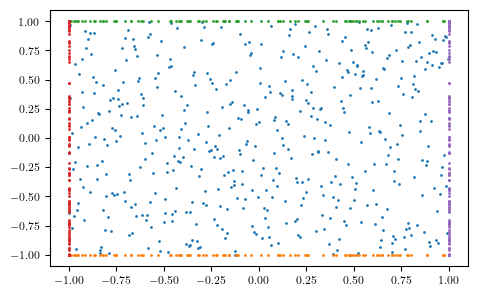

In [8]:
# Define the device
device = torch.device('cuda')

# Initialize iteration counter
iter = 0  

# Define the parameters
A = 1
k = 10

# Define lower and upper bounds for the domain
lb = np.array([-1.0, -1.0])
ub = np.array([1.0, 1.0])  

# Generate sampling points
N_b = 50 
N_f = 500 
 
# Function to generate sampling points
def generate_sampling_points(lb, ub, N):
    c = lb + (ub - lb) * lhs(2, N)
    x = torch.from_numpy(c[:, 0]).float().to(device)
    x.requires_grad = True
    y = torch.from_numpy(c[:, 1]).float().to(device)
    y.requires_grad = True
    return x, y
# Function to generate boundary sampling points
def generate_boundary_sampling_points(lb, ub, N):
    x_b = np.concatenate([
        np.random.uniform(lb[0], ub[0], N),  # x on lower y boundary
        np.random.uniform(lb[0], ub[0], N),  # x on upper y boundary
        np.full(N, lb[0]),                   # x on left x boundary
        np.full(N, ub[0])                    # x on right x boundary
    ])
    y_b = np.concatenate([
        np.full(N, lb[1]),                   # y on lower y boundary
        np.full(N, ub[1]),                   # y on upper y boundary
        np.random.uniform(lb[1], ub[1], N),  # y on left x boundary
        np.random.uniform(lb[1], ub[1], N)   # y on right x boundary
    ])
    x_b = torch.from_numpy(x_b).float().to(device)
    x_b.requires_grad = True
    y_b = torch.from_numpy(y_b).float().to(device)
    y_b.requires_grad = True
    return x_b, y_b

x_f, y_f = generate_sampling_points(lb, ub, N_f)
x_b, y_b = generate_boundary_sampling_points(lb, ub, N_b)

# Initialize the model with specified parameters and apply weights
model = MLP(input_size=2, output_size=2, hidden_layers=5, hidden_units=150, activation_function=nn.Tanh()).to(device)
model.apply(init_weights)

# Function to plot sampling points
def plot_sampling_points(x, y, title):
    x_np = x.cpu().detach().numpy()
    y_np = y.cpu().detach().numpy()
    plt.scatter(x_np, y_np, s=1)


# Plot the sampling points
plot_sampling_points(x_f, y_f, 'Function Sampling Points')
plot_sampling_points(x_b, torch.zeros_like(x_b)-1, 'Boundary Sampling Points')
plot_sampling_points(x_b, torch.zeros_like(x_b)+1, 'Boundary Sampling Points')
plot_sampling_points(torch.zeros_like(x_b)-1, y_b, 'Boundary Sampling Points')
plot_sampling_points(torch.zeros_like(x_b)+1, y_b, 'Boundary Sampling Points')
plt.show()    

In [9]:
#train_adam(model, x_f, y_f, x_b, y_b, A, k, num_iter=1000)
train_lbfgs(model, x_f, y_f, x_b, y_b, A, k, num_iter = 1_000)

LBFGS - Loss: 1.7967056035995483
LBFGS - Loss: 1.336677074432373
LBFGS - Loss: 0.571729302406311
LBFGS - Loss: 0.0970146656036377
LBFGS - Loss: 0.020494826138019562
LBFGS - Loss: 0.006201464682817459
LBFGS - Loss: 0.002699922537431121
LBFGS - Loss: 0.0013896117452532053
LBFGS - Loss: 0.0009213712764903903
LBFGS - Loss: 0.0006335112266242504


In [10]:
# Número de muestras en x y y
dom_samples = 100
x = np.linspace(-1, 1, dom_samples)
y = np.linspace(-1, 1, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

def u_exact(x, y, k):
    ikx = -1j * x * k
    exp_ikx = np.exp(ikx)    
    return exp_ikx

In [11]:
# Convertir los datos X e Y a tensores de PyTorch y cambiar su forma
X_ten = torch.tensor(X).float().reshape(-1, 1).to(device)
Y_ten = torch.tensor(Y).float().reshape(-1, 1).to(device)

# Concatenar los tensores X e Y en un solo tensor
domain_ten = torch.cat([X_ten,Y_ten], dim = 1) 
U_pred = model(domain_ten)
U_real = U_pred[:, 0].detach().cpu().numpy().reshape(X.shape)
U_imag = U_pred[:, 1].detach().cpu().numpy().reshape(X.shape)

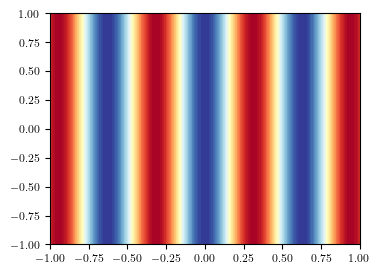

In [12]:
plt.figure(figsize=(4, 3))
plt.contourf(X, Y, np.real(u_exact(X, Y, k)), cmap='RdYlBu', levels=50, vmin=-1, vmax=1)
plt.show()

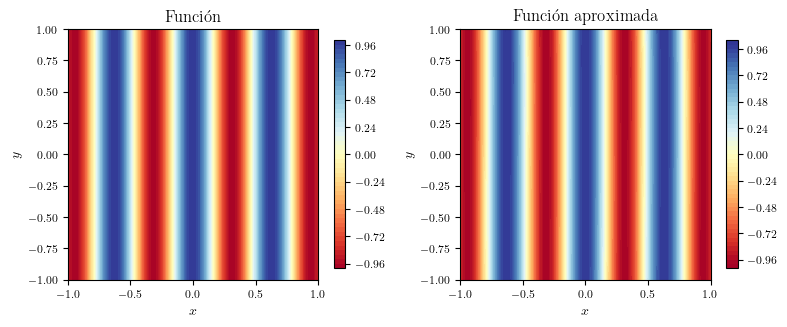

In [13]:
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, np.real(u_exact(X, Y, k)), cmap='RdYlBu', levels=50, vmin=-1, vmax=1)
plt.colorbar(shrink=0.4)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Función")
plt.axis("image")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, U_real, cmap='RdYlBu', levels=50, vmin=-1, vmax=1)
plt.colorbar(shrink=0.4)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Función aproximada")
plt.axis("image")
plt.grid(False)

plt.tight_layout()